<a href="https://colab.research.google.com/github/TheMagicShop/What-Celebrity-are-u/blob/main/which_celebrity_are_U.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**♪ Intorduction:**

* In this Notebook we will try the funny Idea of using Pattern recognition algorithms and Convolutional Neural Networks in order to predict the celebrity that's likely to be the most similar to the person in the extern uplaoded image.

* the celebrities photos are nicely captured and cropped givinig an impeccable frontal images, so make sure to upload your image under the same conditions.

* we will be using quite few Unsupervised Learning algorithms,like KMeansand Principal Component Analysis, to get into the heart of the data and extract what's suitable and what's not for our data.

* moreover, we will be trying to fit the data to a standard Deep Neural Networks models to demonstrate their failure against CNNs.

* also, we will go on a long journey in tweaking and fine tunning the hyperparameters to infer the best model.

* finally we will construct a function that helps in uploading external images and making predictions.


-- The Notebook is very detiled and have some instructive sense.

-- This Notebook uses GPU, otherwise some cells will take a huge time to run.

-- Environment: Python-Jupyter (Google Colaboratory) "GPU"

-- Frameworks: keras, scikit-learn.

The original data set contains 500 celebrities with 10 frontal and 4 profile images each, I decided to use just 80 celebrities with 10 frontal images each.

*Dataset Source: [cfpw.io](http://www.cfpw.io/)*

```
@inproceedings{cfp-paper,
  author = {S. Sengupta, J.C. Cheng, C.D. Castillo, V.M. Patel, R.  Chellappa, D.W. Jacobs},
  Booktitle = {IEEE Conference on Applications of Computer Vision},
  Title = {Frontal to Profile Face Verification in the Wild},
  Month = {February},
  Year = {2016}}
```

# Settings:

In [ ]:
%matplotlib inline 
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

#To Save Our Beatuful Figures
ROOT_DIR = '.'
PLOTS_PATH = os.path.join(ROOT_DIR , "plots")
os.makedirs(PLOTS_PATH , exist_ok=True)
def save_figure(figure_id):
  path = os.path.join(PLOTS_PATH , figure_id + '.png')
  print("saving figure: " , figure_id)
  plt.savefig(path , format='png' , resolution = 300)

In [ ]:
#Uploading the data if you are working in google colab
from google.colab import files
up = files.upload()

Saving zipCelebs.zip to zipCelebs.zip


In [ ]:
%%capture
#Extract the files frop the zip file
!unzip 'zipCelebs.zip'

In [ ]:
N = len(os.listdir('Celebs')) # number of Celebrities in the dataset
print("There is:", N , "Celebrities in this Data Set")
m = len(os.listdir(os.path.join('Celebs' , '01'))) # number of images per Celebrity
print("There is:", m , "photos per Celebrity")

There is: 80 Celebrities in this Data Set
There is: 10 photos per Celebrity


In [ ]:
# Reading names from names_list.txt
# there is one name per line
f = open("names_list.txt" , 'r')
names = f.readlines()
for i in range(N):
  names[i] = names[i][:-1]  #deleting the '\n' character
f.close()

# Converting the data and a first insight:



*   Preparing The Data



In [ ]:
#This Cell of Code is for accessing the images from their directories
#resizing to the desired size, convert them yo numpy arrays
image_shape = [64,64,3]    #the desired image shape (RGB)

def import_image(path, size=image_shape[:2], mode='RGB'):
  if mode == 'gray':
    image = Image.open(path).convert('L') # convert to grayscale if any
  else:
    image = Image.open(path)
  image = image.resize(size)           # resize
  array = np.array(image)                 # to array
  array = array.reshape(1,-1)               # Flattening the image to a vector
  array = array / 255.                      # from [0,255] to [0,1]
  return array
################################################################################
#function that create a whole array that carry all the flattned images 
def import_data(size=image_shape[:2] , mode='RGB'):     
  if mode not in ['RGB' , 'gray'] : return "please choose mode RGB or gray"
  
  f = size[0]*size[1]*3 if mode=='RGB' else size[0]*size[1]

  X = np.empty((N*m , f))
  y = np.empty(N*m , dtype=np.uint16)

  for i in range(N):    ## Looping through Celebrities
    for j in range(m):  ## Looping through their images
      image_path = os.path.join('Celebs','{0:02}'.format(i+1) , '{0:02}.jpg'.format(j+1))
      array = import_image(image_path, size=size, mode=mode)  # image to array
      X[m*i + j] = array   # store the vector in the right place
      y[m*i + j] = i     # target from 0 to N-1
  
  return X,y

In [ ]:
# Splitting the data to training and testing data but conserving
# the percentage of each celebrity in either the train data or test data
# in other words train and test data sets are having the same percentage for each celebrity
# test_size=20% (for example if m=10 then each celebrity has 8 images in train set and 2 in test set)
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits = 1, test_size=.2 , random_state = 808)

X,y = import_data()
for train_indices , test_indices in sss.split(X,y):
  X_train , y_train = X[train_indices] , y[train_indices]
  X_test , y_test = X[test_indices] , y[test_indices]

In [ ]:
## save indices, because why not
np.savetxt("train_indices.csv", train_indices, fmt='%d', delimiter=",")
np.savetxt("test_indices.csv", test_indices, fmt='%d', delimiter=",")



*   An insight about our data set


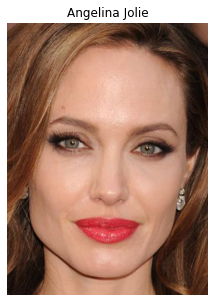

format: JPEG
mode: RGB


In [ ]:
#an example of our data
i = np.random.randint(N)
j = np.random.randint(m)
random_path = os.path.join('Celebs', '{0:02}'.format(i+1), '{0:02}.jpg'.format(j+1))
random_image = Image.open(random_path)
fig = plt.figure(figsize=(5,5))
plt.imshow(random_image)
plt.title(names[i])
plt.axis('off')
plt.show()
print("format: " + random_image.format)
print("mode: " + random_image.mode)

saving figure:  all_Celeb


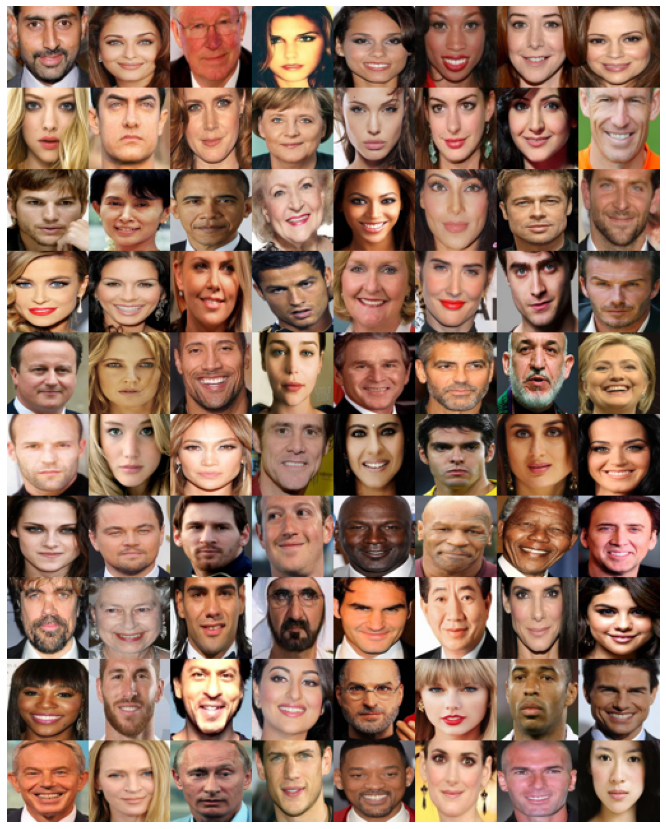

In [ ]:
# let's plot a figure having all celebrities faces in it
all_in_row = X[0].reshape(image_shape)
for i in range(1,N):
  all_in_row = np.hstack((all_in_row , X[10*i].reshape(image_shape)))

all_Celeb = all_in_row[:,:8*image_shape[1],:]
for j in range(1,N//8):
  next_8 = all_in_row[: , j*8*image_shape[1]:(j+1)*8*image_shape[1] , :]
  all_Celeb = np.vstack((all_Celeb , next_8))

plt.figure(figsize=(8*1.5,(N//8)*1.5))
plt.imshow(all_Celeb)
plt.axis('off')
save_figure('all_Celeb')
plt.show()

Plotting the average face over all the images of a certain celebrity in the

data set can give an insight about the variance of these images of that person

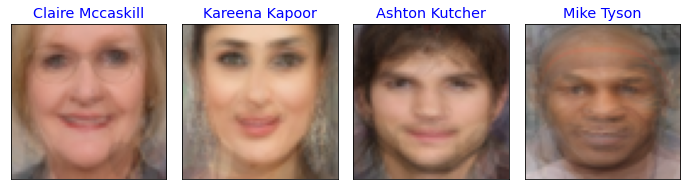

In [ ]:
random_indices = np.random.randint(0, N , 4)
fig , ax = plt.subplots(1,4 , figsize=(12,6),
                        subplot_kw={'xticks':[] , 'yticks':[]})
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(4):
  x = random_indices[i]
  average_celeb_face = X[m*x:m*(x+1)].mean(axis=0)
  average_celeb_face = average_celeb_face.reshape(image_shape)
  its_name = names[x]

  ax[i].imshow(average_celeb_face)
  ax[i].set_title(its_name , color='b' , fontsize='x-large')

The Average Face over all the images in the data set 

saving figure:  average_face


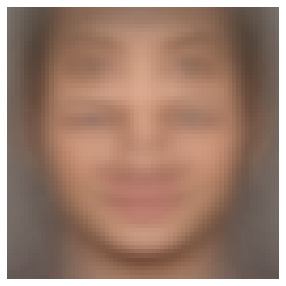

In [ ]:
fig = plt.figure(figsize=(5,5))
average_face = X.mean(axis=0).reshape(image_shape)
plt.imshow(average_face)
plt.axis('off')
save_figure('average_face')
plt.show()

# DataViz:



*   Principal Component Analysis



This Mathematical Dimensionality Reduction tool can extract the most (in our case `n_components = 5`)
pertinent axes that we can use to represent our data, instead of all the pixels used for representing an image.

We can see in the following plots the most useful face features that represent the data set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saving figure:  principal_components


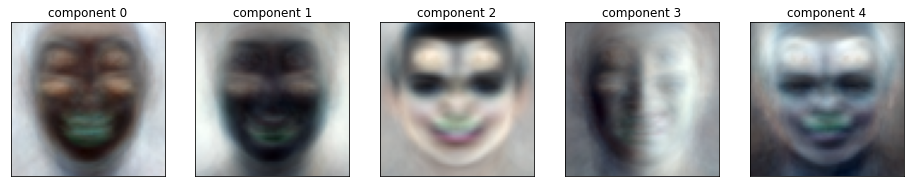

In [ ]:
from sklearn.decomposition import PCA , KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler = StandardScaler()  ## it's preferred to scale the data beforing passing it to PCA
mmx_scaler = MinMaxScaler()  ## scaling back the data to [0,1] range to visualize the RGB images
pca = PCA(n_components = 5)

X_1 = std_scaler.fit_transform(X)
X_pca = pca.fit_transform(X_1)

pca_components = pca.components_   ## the most 5 important axes (vectors)(images)
cp_images = mmx_scaler.fit_transform(pca_components.T)
fig , ax = plt.subplots(1,5,figsize=(16,20),
                        subplot_kw={'xticks':[],'yticks':[]})
for i in range(5):
  image = cp_images.T[i].reshape(image_shape)
  ax[i].imshow(image)
  ax[i].set_title("component " +str(i))
  
save_figure('principal_components')



*   Pixels Importances


we will be using the supervised algorithm `SelectPercentile` to derive the most impactful pixels on our target vector.

saving figure:  features_importances


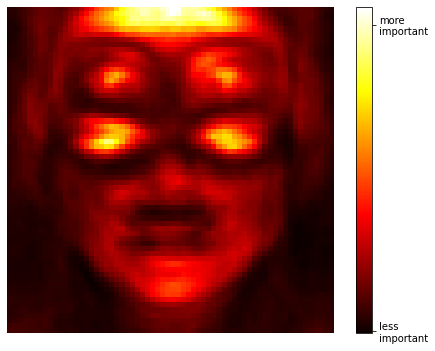

In [ ]:
from sklearn.feature_selection import SelectPercentile

sp = SelectPercentile()
sp.fit(X,y)
scores=sp.scores_.reshape(image_shape)[:,:,0]

fig = plt.figure(figsize=(8,6))
plt.imshow(scores , cmap='hot')
cbar=plt.colorbar(ticks=[1.1*scores.min(),.95*scores.max()])
cbar.ax.set_yticklabels(['less\nimportant','more\nimportant'])
plt.axis('off')
save_figure('features_importances')

The three consecutive previous plots showed that the position of the eyes in 
the face varies from one face to another.

in order to use other standard Machine Learning algorithms and not to crash the RAM memory we need to reduce the dimensionality of our data, so let's work a bit with some grayscale images.

In [ ]:
## Xg includes the grayscale images
image_gray_shape = [64,64]
Xg , _ = import_data(size=image_gray_shape , mode='gray')
for train_indices, test_indices in sss.split(Xg,_):
  Xg_train = Xg[train_indices]
  Xg_test  = Xg[test_indices]




*   Clustering

we will be using `KMeans` with number of clusters `n_clusters=8` to see if we can divide our data to 8 classes, and the centroid faces that represent these classes.

saving figure:  centroids


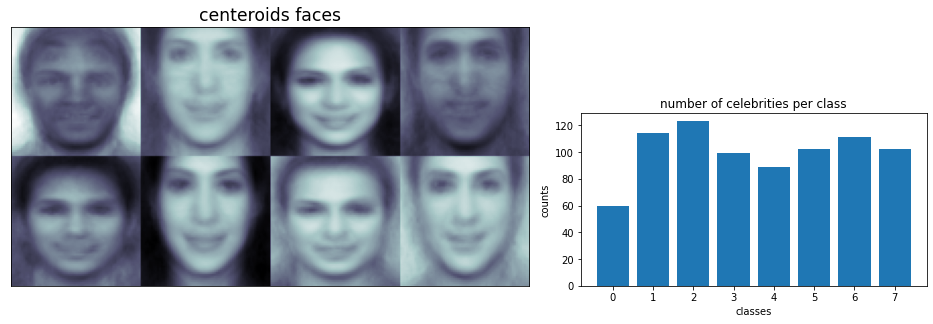

In [ ]:
from sklearn.cluster import KMeans

nrow , ncol = 2,4
n = nrow*ncol
kmeans = KMeans(n_clusters=n, init='k-means++', n_jobs=-1)
kmeans.fit(Xg)

u,c = np.unique(kmeans.labels_ , return_counts=True)
centers = kmeans.cluster_centers_      # centers
centers = centers.reshape([-1]+image_gray_shape)  # reshaping centers to an appropriate image shape

img = centers[0]
for j in range(1,ncol):
  img = np.hstack((img , centers[j]))
for i in range(1,nrow):
  row = centers[i*ncol]
  for j in range(1,ncol):
    row = np.hstack((row , centers[i*ncol + j]))
  img = np.vstack((img , row))


fig = plt.figure(figsize=(4*ncol,2*nrow))

ax1 = fig.add_axes([0.01,0.1,0.6,0.9], xticks=[],yticks=[])
ax1.set_title('centeroids faces', fontdict={'fontsize':'xx-large'})
ax1.set_xticklabels(np.arange(1,n+1))
ax1.imshow(img , cmap='bone')

ax2 = fig.add_axes([0.58,0.1,0.3,0.6], title='number of celebrities per class')
ax2.bar(u,c)
ax2.set_xlabel('classes')
ax2.set_ylabel('counts')

save_figure('centroids')
plt.show()

del kmeans, centers

Note that these centers faces are imaginary and do not exist in the data set.

# Typical ML Model:

tackling an ordinary ML algorithm won't help but also won't hurt (actually it will hurt your time consumption because of the enormity of the dataset's  dimensionality)

In [ ]:
%%time 
## Disclamer "running this code will take 5 min (GPU)"
from sklearn.linear_model import LogisticRegression

C_param = [10**n for n in range(-3,4)]
best_score = 0
best_lr = 0
for C in C_param:
  lr = LogisticRegression(solver='newton-cg', C=C, max_iter=500, n_jobs=-1)
  lr.fit(Xg_train , y_train)

  train_score , test_score = lr.score(Xg_train, y_train) , lr.score(Xg_test, y_test)
  print("C =", C, "  ::  ", train_score,test_score)
  if test_score > best_score :
     best_score = test_score
     best_lr = lr
  del lr
print("\n\n")

C = 0.001   ::   0.5 0.21875
C = 0.01   ::   0.8375 0.4125
C = 0.1   ::   1.0 0.48125
C = 1   ::   1.0 0.49375
C = 10   ::   1.0 0.50625
C = 100   ::   1.0 0.5125
C = 1000   ::   1.0 0.55



CPU times: user 447 ms, sys: 731 ms, total: 1.18 s
Wall time: 4min 56s


let's create a function that show each image next to the wrong assignement made by the algorithm (if it's mispredicted) 

In [ ]:
def messy_celeb(y_true, y_pred, n):
  
  mask = y_true != y_pred
  if sum(mask) < n : return "Please choose n<=" + str(sum(mask))
  
  true_classes = y_true[mask][:n]
  true_images = X_test[mask][:n]
  wrong_classes = y_pred[mask][:n]
  wrong_images = X[10*wrong_classes]


  nrow = n//3 + int(n%3!=0)
  fig,axes = plt.subplots(nrow , 3 ,figsize=(15,3*nrow))
  fig.subplots_adjust(hspace=0.1, wspace=0.1)
  fig.suptitle(y=.89,t='True Face | Wrong Prediction', fontsize=20)

  for i in range(n):
    ax = axes.ravel()[i]
    true_image = true_images[i].reshape(image_shape)
    wrong_image = wrong_images[i].reshape(image_shape)
    image = np.hstack((true_image,wrong_image))

    true_celeb = names[true_classes[i]]
    wrong_celeb = names[wrong_classes[i]]

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(true_celeb + ' | ' + wrong_celeb ,
                  fontdict={'fontsize':'large' , 'color':'b'})
    ax.imshow(image)
  
  i+=1
  while i<3*nrow:
    axes.ravel()[i].set_axis_off()
    i+=1

#title first n wrong assignements

saving figure:  lr_wrong_pred


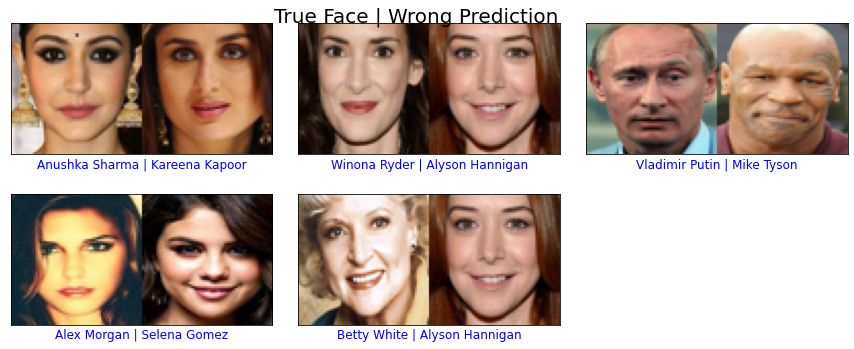

In [ ]:
messy_celeb(y_test , best_lr.predict(Xg_test) , 5)
save_figure("lr_wrong_pred")

In [ ]:
del best_lr #bye!

# Typical DNN Models:

Now we will switch to Deep Neural Networks (without CNN) and see how it does on our data

In [ ]:
## creating a function that plots the accuracy and loss curves 
def acc_nd_loss(h):
  fig = plt.figure(figsize=(20,4))
  fig.subplots_adjust(wspace=0.2)

  plt.subplot(1,2,1)
  plt.plot(h.history['accuracy'] , label='train_acc')
  plt.plot(h.history['val_accuracy'] , label='test_acc')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.grid(True)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(h.history['loss'] , label='train_los')
  plt.plot(h.history['val_loss'] , label='test_loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend()
  
  plt.show()

first dummy sequential model with the least parameters possible to see how it works

In [ ]:
dummy_model = keras.Sequential([
                                keras.layers.InputLayer(input_shape=X[0].shape),
                                keras.layers.Dense(units=3000),
                                keras.layers.Dense(units=N , activation='softmax')])
                                # softmax because of the multiclassification task

dummy_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#sparse because the a single target is a single scalar and not a vector

h_d = dummy_model.fit(X_train,y_train,
                    validation_data=(X_test,y_test),epochs=40) 

Epoch 1/40
20/20 [==============================] - 4s 44ms/step - loss: 243.6719 - accuracy: 0.0260 - val_loss: 284.7619 - val_accuracy: 0.0188
Epoch 2/40
20/20 [==============================] - 0s 20ms/step - loss: 280.0346 - accuracy: 0.0284 - val_loss: 187.5305 - val_accuracy: 0.0250
Epoch 3/40
20/20 [==============================] - 0s 19ms/step - loss: 157.9621 - accuracy: 0.0414 - val_loss: 136.2674 - val_accuracy: 0.0500
Epoch 4/40
20/20 [==============================] - 0s 19ms/step - loss: 132.6120 - accuracy: 0.0592 - val_loss: 140.2827 - val_accuracy: 0.0562
Epoch 5/40
20/20 [==============================] - 0s 19ms/step - loss: 128.8360 - accuracy: 0.0850 - val_loss: 160.3930 - val_accuracy: 0.0375
Epoch 6/40
20/20 [==============================] - 0s 19ms/step - loss: 123.0914 - accuracy: 0.0717 - val_loss: 101.9519 - val_accuracy: 0.0812
Epoch 7/40
20/20 [==============================] - 0s 19ms/step - loss: 112.5261 - accuracy: 0.1001 - val_loss: 116.8372 - val_ac

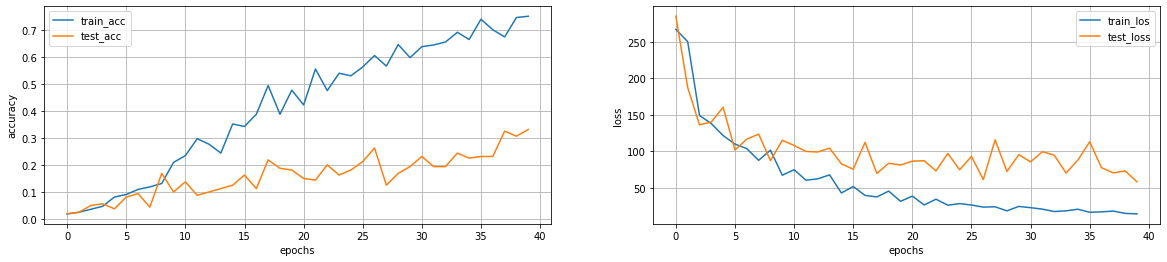

In [ ]:
acc_nd_loss(h_d)

the accuracy curves going up'n'down is obviously not satisfying, buts it's just a dummy model

let's see its wrong predictions

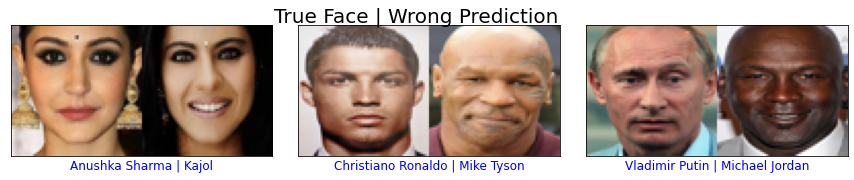

In [ ]:
dummy_y_pred = dummy_model.predict(X_test).argmax(axis=1)
messy_celeb(y_test,dummy_y_pred,3)

in this second model we will try some kind of regulirazers, namely l1 regularizer, to fight overfitting.

In [ ]:
model_01 = keras.Sequential([
                             keras.layers.InputLayer(input_shape=Xg[0].shape),
                             keras.layers.Dense(units=2048, kernel_regularizer=keras.regularizers.l1(l1=.1)),
                             
                             keras.layers.Dense(units=1024, kernel_regularizer=keras.regularizers.l1(l1=.1)),
                             
                             keras.layers.Dense(units=N , activation='softmax', kernel_regularizer='l2')
])

model_01.compile(
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

h_01 = model_01.fit(Xg_train,y_train,
                 validation_data=(Xg_test,y_test),epochs=30)

Epoch 1/30
20/20 [==============================] - 1s 16ms/step - loss: 10325.3966 - accuracy: 0.0180 - val_loss: 1156.9944 - val_accuracy: 0.0125
Epoch 2/30
20/20 [==============================] - 0s 10ms/step - loss: 850.3126 - accuracy: 0.0286 - val_loss: 524.7956 - val_accuracy: 0.0063
Epoch 3/30
20/20 [==============================] - 0s 10ms/step - loss: 530.9686 - accuracy: 0.0093 - val_loss: 521.1544 - val_accuracy: 0.0125
Epoch 4/30
20/20 [==============================] - 0s 10ms/step - loss: 528.4429 - accuracy: 0.0084 - val_loss: 520.4946 - val_accuracy: 0.0125
Epoch 5/30
20/20 [==============================] - 0s 10ms/step - loss: 527.9611 - accuracy: 0.0058 - val_loss: 520.3470 - val_accuracy: 0.0125
Epoch 6/30
20/20 [==============================] - 0s 10ms/step - loss: 527.8509 - accuracy: 0.0057 - val_loss: 520.3187 - val_accuracy: 0.0188
Epoch 7/30
20/20 [==============================] - 0s 10ms/step - loss: 527.8282 - accuracy: 0.0053 - val_loss: 520.3270 - val

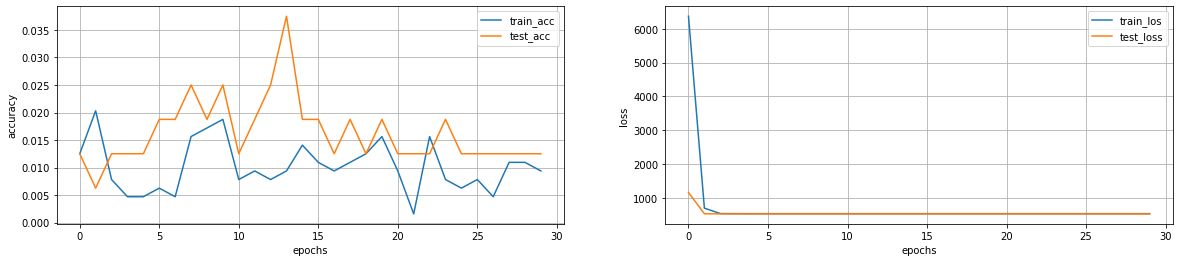

In [ ]:
acc_nd_loss(h_01)

the accuracy curves end up being worse than the previous model.

now let's try to put some BatchNormalization in it, which performs quit robustly in most of cases.

also changing the weights initilizer to `'he_normal` and the activation function to `'elu'`

In [ ]:
model_02 = keras.Sequential([
                             keras.layers.InputLayer(input_shape=Xg[0].shape),
                             keras.layers.BatchNormalization(),
                             keras.layers.Dense(units=2048, kernel_initializer='he_normal', activation='elu'),
                             keras.layers.BatchNormalization(),
                             keras.layers.Dense(units=1024, kernel_initializer='he_normal', activation='elu'),
                             keras.layers.BatchNormalization(),
                             keras.layers.Dense(units=N , activation='softmax')
])

model_02.compile(loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

h_02 = model_02.fit(Xg_train,y_train,
                 validation_data=(Xg_test,y_test),epochs=30)

Epoch 1/30
20/20 [==============================] - 1s 16ms/step - loss: 6.3442 - accuracy: 0.0821 - val_loss: 16.2029 - val_accuracy: 0.0125
Epoch 2/30
20/20 [==============================] - 0s 9ms/step - loss: 2.0192 - accuracy: 0.4307 - val_loss: 6.9948 - val_accuracy: 0.0500
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 1.0478 - accuracy: 0.7038 - val_loss: 6.2231 - val_accuracy: 0.0750
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 0.6592 - accuracy: 0.8066 - val_loss: 4.3948 - val_accuracy: 0.1312
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 0.3514 - accuracy: 0.8878 - val_loss: 3.9812 - val_accuracy: 0.1937
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 0.4590 - accuracy: 0.8678 - val_loss: 4.1579 - val_accuracy: 0.2125
Epoch 7/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2666 - accuracy: 0.9145 - val_loss: 3.6139 - val_accuracy: 0.2125
Epoch 8/30
20/20 [

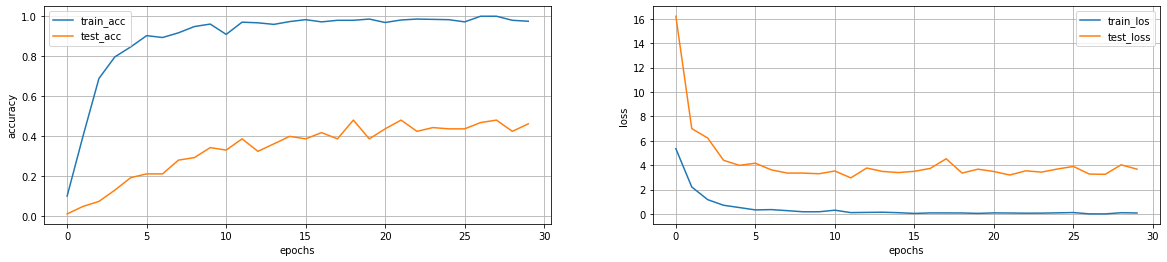

In [ ]:
acc_nd_loss(h_02)

BatchNormalization is obviously helpful, but we end up again with a huge overfitting issue.

that's why in the next model we will try to add a regularization term (not l1 but) Dropout, also constrain the wights to have a specified norm `max_norm=0.5`,
and using another faster optimizer `keras.optimizers.Nadam()` with a learning_rate `learning_rate=.0001`.

In [ ]:

model_03 = keras.Sequential([
                             keras.layers.InputLayer(input_shape=Xg[0].shape),
                             keras.layers.BatchNormalization(),
                             keras.layers.Dense(units=2048, kernel_initializer='he_normal', activation='elu',
                                                kernel_constraint=keras.constraints.max_norm(.5)),
                             keras.layers.Dropout(.5),
                             keras.layers.BatchNormalization(),
                             keras.layers.Dense(units=1024, kernel_initializer='he_normal', activation='elu',
                                                kernel_constraint=keras.constraints.max_norm(.5)),
                             keras.layers.Dropout(.5),
                             keras.layers.BatchNormalization(),
                             keras.layers.Dense(units=512, kernel_initializer='he_normal', activation='elu',
                                                kernel_constraint=keras.constraints.max_norm(.3)),
                             keras.layers.Dropout(.5),
                             keras.layers.BatchNormalization(),
                             keras.layers.Dense(units=256, kernel_initializer='he_normal', activation='elu',
                                                kernel_constraint=keras.constraints.max_norm(.3)),
                             keras.layers.Dropout(.5),
                             keras.layers.BatchNormalization(),
                             keras.layers.Dense(units=N , activation='softmax')
])

model_03.compile(optimizer=keras.optimizers.Nadam(learning_rate=.0001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

h_03 = model_03.fit(Xg_train,y_train,batch_size=64,
                 validation_data=(Xg_test,y_test),epochs=60)

Epoch 1/60
10/10 [==============================] - 2s 41ms/step - loss: 5.0176 - accuracy: 0.0126 - val_loss: 4.3690 - val_accuracy: 0.0312
Epoch 2/60
10/10 [==============================] - 0s 19ms/step - loss: 4.3937 - accuracy: 0.0399 - val_loss: 4.3531 - val_accuracy: 0.0250
Epoch 3/60
10/10 [==============================] - 0s 19ms/step - loss: 3.9621 - accuracy: 0.0678 - val_loss: 4.3342 - val_accuracy: 0.0250
Epoch 4/60
10/10 [==============================] - 0s 19ms/step - loss: 3.7372 - accuracy: 0.1179 - val_loss: 4.3113 - val_accuracy: 0.0250
Epoch 5/60
10/10 [==============================] - 0s 18ms/step - loss: 3.5676 - accuracy: 0.1323 - val_loss: 4.2847 - val_accuracy: 0.0312
Epoch 6/60
10/10 [==============================] - 0s 18ms/step - loss: 3.3574 - accuracy: 0.1628 - val_loss: 4.2569 - val_accuracy: 0.0562
Epoch 7/60
10/10 [==============================] - 0s 18ms/step - loss: 3.2180 - accuracy: 0.2036 - val_loss: 4.2241 - val_accuracy: 0.1125
Epoch 8/60
10

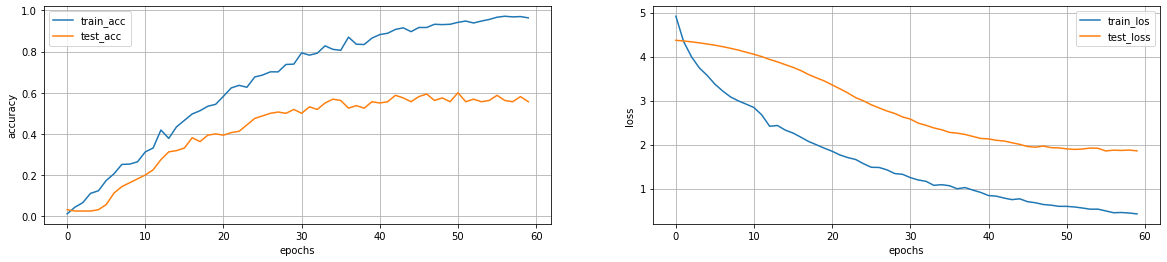

In [ ]:
# even thoug 0.5>0.4 :P
acc_nd_loss(h_03)

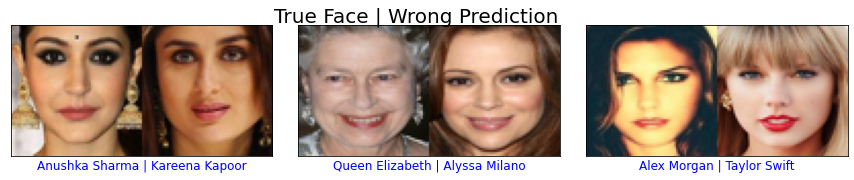

In [ ]:
y_pred_03 = model_03.predict(Xg_test).argmax(axis=1)
messy_celeb(y_test, y_pred_03, 3)

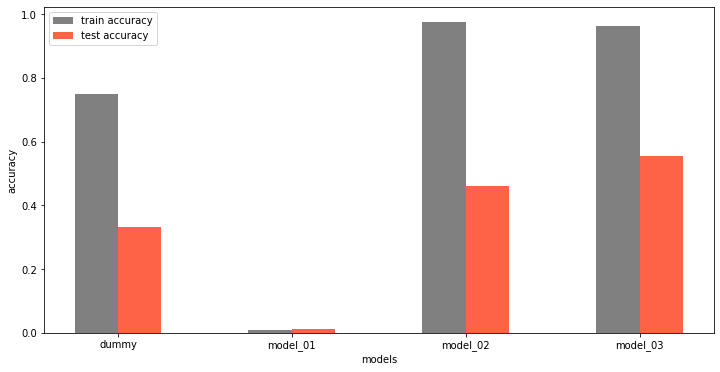

In [ ]:
# trying to compare these models
train_acc=[h.history['accuracy'][-1] for h in [h_d, h_01, h_02, h_03]]
test_acc=[h.history['val_accuracy'][-1] for h in [h_d, h_01, h_02, h_03]]
x=np.array([2,4,6,8])
text=[]
w=.5

fig = plt.figure(figsize=(12,6))

plt.bar(x-w/2, train_acc, w, label='train accuracy', color='gray')
plt.bar(x+w/2, test_acc, w, label='test accuracy', color='tomato')

plt.xticks(x, labels=['dummy','model_01','model_02','model_03'])
plt.ylabel('accuracy')
plt.xlabel('models')
plt.legend()
plt.show()

not bad we learned some few things to keep in mind (like saying no to l1 regularizer) when we will be using CNN.

In [ ]:
del dummy_model, model_01, model_02
del model_03, h_d,h_01,h_02,h_03
del Xg, Xg_train, Xg_test

# Diving into CNN:

Now let's dive into the Convolutional Neural Networks since the ordinary Machine Learning and Deep Neural Networks failed to build a good model.

In [ ]:
## reshape back the images to their original shape (not vectors anymore)
## we will be working with the RGB images
X = X.reshape([-1]+image_shape)
X_train = X_train.reshape([-1]+image_shape)
X_test = X_test.reshape([-1]+image_shape)

Since we will be repeating the same procces in building models, let's create a function that makes this easier.

this function has quite a few parameters to tweak, assuring some sort of flexibility and permitting us to fine tuning some hyperparameters.

In [ ]:
def build_model(hidden_layers_units=[2048,1024,512], activation='elu', initializer='he_normal', drop_rate=0, 
                n_conv_filters=[32,64,128], kernels_sizes=[7,5,3], 
                optimizer='sgd', learning_rate=0.01, **kwargs):
  
  ## instantiate the model
  model = keras.Sequential([keras.layers.InputLayer(input_shape=image_shape)])
  
  ## adding Convolutional layers (filters and kernel_size) are free to tune
  for filters,kernel_size in zip(n_conv_filters,kernels_sizes):
    model.add(keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='SAME',
                                  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.MaxPool2D(pool_size=2))

  ## adding a Flatten layer to flatten the data from high-dimensional tensors to vectors
  model.add(keras.layers.Flatten())

  ## addind Dense Layers number of layers, units, activation, kernel_initializer and drop rate 
  ## are free to tweak
  for units in hidden_layers_units:
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(units=units, activation=activation,
                                 kernel_initializer=initializer, **kwargs))
    model.add((keras.layers.Dropout(drop_rate)))
  
  model.add(keras.layers.Dense(units=N, activation='softmax'))

  ## optimizer and learning_rate
  opt = keras.optimizers.get(optimizer)
  opt.learning_rate = learning_rate
  ## finally compile the model
  model.compile(optimizer = opt , metrics=['accuracy'],
                loss='sparse_categorical_crossentropy')
  
  return model

In [ ]:
## why not a callback (Early Stopping) that stops the model when the validation loss 
## is getting no better for 10 epochs and turn back to that model better model
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

next we will be using some sort of grid search (manually) looking for the best parameters values to implement in our model.

and along the way we will be obviously using these best parameters given by the grid search.



1.   Drop out Rate (Search):


now let's add a regularization term (remember no l1 or l2) Dropout.

In [ ]:
%%time
rates = [0,.1,.2,.3,.4,.5,.6,.7]  ##drop_rate
drop_results = []                  ##results of each run

for drop_rate in rates:
  tmp = build_model( drop_rate = drop_rate )
  
  h = tmp.fit(X_train,y_train,validation_data=(X_test,y_test),
                epochs=60,batch_size=16,verbose=0,callbacks=[early_stopping])
  
  t_score = tmp.evaluate(X_test,y_test,verbose=0)[1]  ## test score
  drop_results.append(t_score)                

  del tmp, h

  z = int(drop_rate*10) + 1
  print('[' + '='*z + '.'*(len(rates)-z) + ']' , end=' ')

print()

[=.......] [==......] [===.....] [====....] [=====...] [======..] [=======.] [========] 
CPU times: user 1min 27s, sys: 4.54 s, total: 1min 31s
Wall time: 1min 40s


saving figure:  tunning_drop_rate


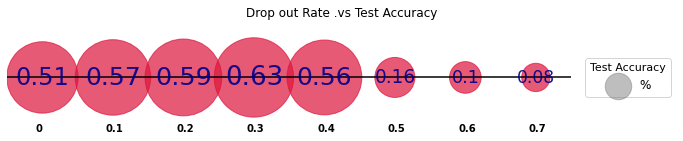

In [ ]:
drop_results = np.round(drop_results,2)

fig = plt.figure(figsize=(12,2))

plt.scatter(rates, [0]*len(rates), s=10000*drop_results, c='crimson', alpha=.7)

for i in range(len(rates)):
  d, x = rates[i], drop_results[i]
  plt.text(d, 0, x, ha='center', va='center', 
           fontdict={'fontsize':16*(x+1),'color':'darkblue','alpha':.9})
  plt.text(d-.01, -3, str(d),fontdict={'fontweight':'bold'})
  
plt.xlim(-0.05, rates[-1] + 0.2)
plt.ylim(-3,3)
plt.hlines(0, rates[0]-.05, rates[-1]+.05)
plt.axis('off')
plt.title('Drop out Rate .vs Test Accuracy')

plt.scatter([],[],s=700,c='gray',alpha=.5,label='%')
plt.legend(loc='center right',title='Test Accuracy',
           title_fontsize=11,prop={'size':12})

save_figure('tunning_drop_rate')
plt.show()
del fig

2.   Optimizer and Learning Rate (Search):


[=...............] 1/16    [==..............] 2/16    [===.............] 3/16    [====............] 4/16    
[=====...........] 5/16    [======..........] 6/16    [=======.........] 7/16    [========........] 8/16    
[=========.......] 9/16    [==========......] 10/16    [===========.....] 11/16    [============....] 12/16    
[=============...] 13/16    [==============..] 14/16    [===============.] 15/16    [================] 16/16    
saving figure:  learning_rate_CNN_comparison


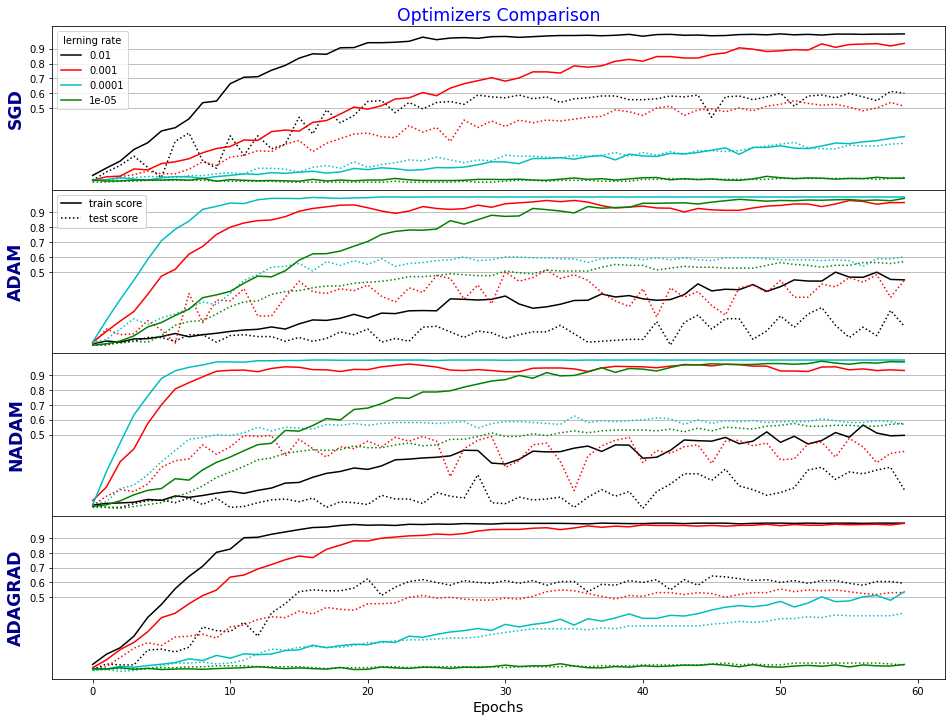

CPU times: user 4min 50s, sys: 17.9 s, total: 5min 8s
Wall time: 7min 37s


In [ ]:
%%time
## Disclamer "running this code will take 8 min (GPU)"
opt_param = ['sgd','adam','nadam','adagrad'] ## optimizers to try
lr_param = [10**-n for n in range(2,6)]  ## learning_rates to try

colors=['k','r','c','g']
fig , ax = plt.subplots(4,1,figsize=(16,12))
fig.subplots_adjust(hspace=0.0)

test_scores = pd.DataFrame(np.ones((4,4)), index=opt_param, columns=lr_param)
test_scores.index.name = 'Optimizer'
test_scores.columns.name = 'Learning Rate'

for i in range(4):                       ##looping through optimizers
  for j in range(4):                     ##looping through learning rates
    temp = build_model(optimizer=opt_param[i], learning_rate=lr_param[j],  ##build that model
                       drop_rate=.3) 
    hist = temp.fit(X_train, y_train,                                     ## fit it
            validation_data=(X_test,y_test),
            batch_size=16, epochs=60, verbose=0)
    
    z = 4*i+j+1
    print('[' + '='*z + '.'*(16-z) + ']' + ' {}/16'.format(z),end='    ') ## some unnecessary details

    ax[i].plot(hist.history['accuracy'], '-'+colors[j],           ##train accuracy
                label=lr_param[j])                          
    ax[i].plot(hist.history['val_accuracy'], ':'+colors[j])       ##test accuracy
    ax[i].grid(True, axis='y')
    ax[i].set_xticks([])
    ax[i].set_yticks([.5,.6,.7,.8,.9])
    ax[i].set_ylabel(opt_param[i].upper(),
                     fontdict={'fontsize':'xx-large', 'fontweight':'bold', 'color':'darkblue'})
    
    test_scores[lr_param[j]][opt_param[i]] = hist.history['val_accuracy'][-1]

    del temp, hist

  print()

ax[0].set_title('Optimizers Comparison', fontdict={'fontsize':'xx-large', 'color':'b'})

ax[3].set_xticks(np.arange(7)*10)
ax[3].set_xlabel('Epochs', fontdict={'fontsize':'x-large'})

ax[0].legend(loc='upper left', title='lerning rate')
l1, = ax[1].plot([],[], '-k')
l2, = ax[1].plot([],[], ':k')
leg2 = ax[1].legend([l1,l2],['train score','test score'],loc='upper left')
ax[1].add_artist(leg2)

save_figure('learning_rate_CNN_comparison')
plt.show()
del fig

we are clearly looking for an optimizer and a learning rate that minimize the overfitting and perform well on the testing data, all these optimizers does the same stochastic process in learning weights and are based exclusively on stochastic gradient descent, but i'm comfortable with the one that converge slowely because its the less likely to overfit.

In [ ]:
print("\n\nTEST SCORES ACHIEVED BY VARIOUS OPTIMIZERs AND LEARNING_RATEs: \n")
display(test_scores)



TEST SCORES ACHIEVED BY VARIOUS OPTIMIZERs AND LEARNING_RATEs: 



Learning Rate  0.01000  0.00100  0.00010  0.00001
Optimizer                                        
sgd            0.60000  0.51250  0.26250  0.03125
adam           0.13750  0.44375  0.60000  0.56875
nadam          0.13125  0.38750  0.56875  0.57500
adagrad        0.59375  0.53125  0.39375  0.04375



3.   Activation and Kernel initializer (Search):



In [ ]:
%%time
## Disclamer "running this code will take 9 min (GPU)"

activ_param = ['relu', 'elu', 'selu', 'sigmoid', 'tanh']
init_param = ['glorot_normal','glorot_uniform','he_normal','he_uniform','lecun_normal']
results = []

for i in range(5):               ##looping through the activation functions
  for j in range(5):             ##looping through the kernel initializers
    temp = build_model(optimizer='adam',learning_rate=10**-4,drop_rate=.3,
                      activation=activ_param[i], initializer=init_param[j])
    temp.fit(X_train,y_train,validation_data=(X_test,y_test),
            epochs=60, callbacks=[early_stopping],   ##using the callback
            batch_size=16, verbose=0)
    
    sc = temp.evaluate(X_test,y_test,verbose=0)[1]    ##test score using the best weights
    results.append(np.round(sc,3))

    z = 5*i+j+1
    print('[' + '*'*z + '.'*(25-z) + ']' + '{}/25'.format(z),end='')
    
    del temp
  print()

[*........................]1/25[**.......................]2/25[***......................]3/25[****.....................]4/25[*****....................]5/25
[******...................]6/25[*******..................]7/25[********.................]8/25[*********................]9/25[**********...............]10/25
[***********..............]11/25[************.............]12/25[*************............]13/25[**************...........]14/25[***************..........]15/25
[****************.........]16/25[*****************........]17/25[******************.......]18/25[*******************......]19/25[********************.....]20/25
[*********************....]21/25[**********************...]22/25[***********************..]23/25[************************.]24/25[*************************]25/25
CPU times: user 6min 16s, sys: 21.6 s, total: 6min 38s
Wall time: 8min 36s


saving figure:  activations_and_initializations_CNN


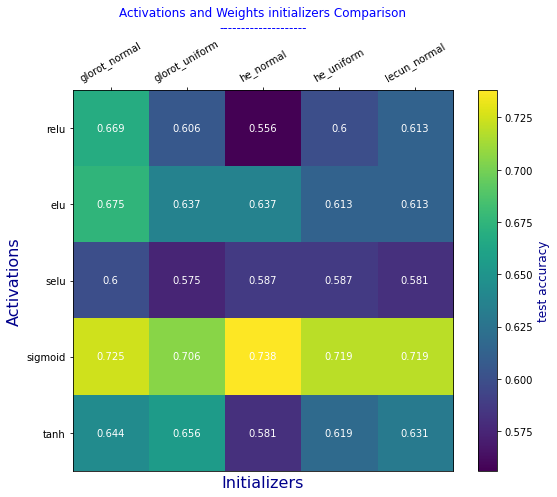

In [ ]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
###############################################################################

## HeatMap
results = np.array(results).reshape((5,5))

fig = plt.figure(figsize=(9,7))

plt.imshow(results, cmap='viridis')
cbar = plt.colorbar()
cbar.ax.set_ylabel('test accuracy',fontdict={'fontsize':12,'color':'darkblue'})
plt.title('Activations and Weights initializers Comparison\n'+'-'*20, fontdict={'color':'b'})
plt.xticks(np.arange(5),labels=init_param, rotation=30)
plt.yticks(np.arange(5),labels=activ_param)
plt.xlabel('Initializers', fontdict={'fontsize':16,'color':'darkblue'})
plt.ylabel('Activations', fontdict={'fontsize':16,'color':'darkblue'})
for i in range(5):
  for j in range(5):
    text = plt.text(j, i, results[i,j], ha='center', va='center', color='w')

save_figure('activations_and_initializations_CNN')
plt.show()
del fig

###############################################################################
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

we can see that the sigmoid activation outperforms all the other activations.



4.   Number of Convolutional Layers (Search):



tweaking the `n_conv_filters` along with `kerne_sizes`, allow implicitly to teweak the number of convolutional layers, and hence the max_pooling layers.


we will also calculate the time spent by each model having its own number of convolutional layers, because each time we add a max_pool layer we divide the data dimensionality by 4. so the fewer max_pool layers are the more cumbersome the model tend to be, and higher number of max_pool risks to loose informations.

1/4 Done in: 1m6s    2/4 Done in: 0m23s    3/4 Done in: 0m13s    4/4 Done in: 0m12s    
saving figure:  n_max_pooling__vs__test_accuracy


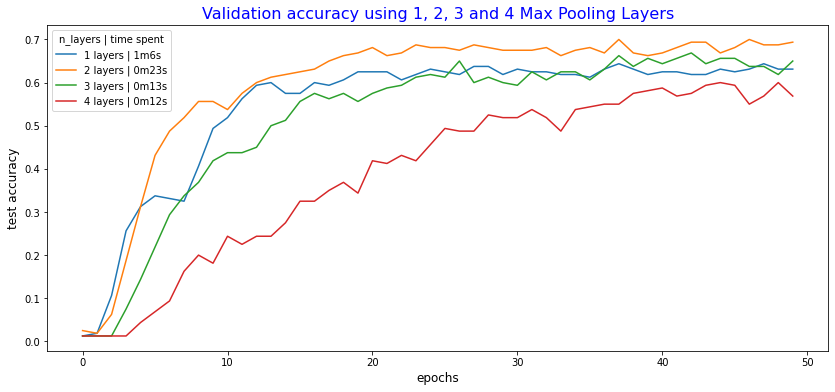

In [ ]:
n_maxpooling_layers=np.arange(1,5)

fig = plt.figure(figsize=(14,6))

for i in n_maxpooling_layers:
  tic = time.time()   ## we want to calculate the time spent by each model

  tmp = build_model(activation='sigmoid', initializer='he_normal',
                    optimizer='adam',learning_rate=10**-4,drop_rate=.3,
                    n_conv_filters=[64]*i, kernels_sizes=[3]*i)
  h = tmp.fit(X_train,y_train,validation_data=(X_test,y_test),
              epochs=50,batch_size=16,verbose=0)
  
  toc = int(time.time() - tic); toc = str(toc//60) + 'm' + str(toc%60) + 's'  ## we want to calculate the time spent by each model

  print('{}/4'.format(i)+' Done in: '+toc, end='    ')

  plt.plot(h.history['val_accuracy'], label=str(i)+' layers | ' +toc)

  del tmp, h
print()

plt.legend(title='n_layers | time spent')
plt.xlabel('epochs', fontdict={'fontsize':12})
plt.ylabel('test accuracy', fontdict={'fontsize':12})
plt.title('Validation accuracy using 1, 2, 3 and 4 Max Pooling Layers',
          fontdict={'fontsize':16,'fontweight':10,'color':'b'})

save_figure('n_max_pooling__vs__test_accuracy')
plt.show()
del fig



5.   Number of Filters and Kernel Size (Search):


until now we are already doing well with this tough classificatino task,
so next we will be using just two convolutional layers with the kernel_size of the second layer is set to 3 `kernel_size2=3`, and we will be searching just for the number of filters of both layers plus the kernel size of the first layer.

In [ ]:
%%time
## Disclamer "running this code will take 25 min (GPU)"

n_filter1 = [32,64,128]
n_filter2 = [64,128,256]
kernel_size1 = [5,7,9]
kernel_size2 = 3

xx = []
yy = []
ss = []
cc = []

for i in range(3):        ## first n_filters
  for j in range(3):      ## second n_filters
    for k in range(3):    ## first kernel_size
      tic = time.time()

      tmp = build_model(activation='sigmoid', initializer='he_normal',
                        optimizer='adam',learning_rate=10**-4,drop_rate=.3,
                        n_conv_filters=[n_filter1[i],n_filter2[j]] , kernels_sizes=[kernel_size1[k], kernel_size2])
      h = tmp.fit(X_train,y_train,validation_data=(X_test,y_test),
                  epochs=50,batch_size=16,verbose=0,callbacks=[early_stopping])
      test_score = h.history['val_accuracy'][-1]

      xx.append(i*2+2)
      yy.append(j*8+4+k)
      ss.append((k+1)*100)
      cc.append(test_score)

      toc = int(time.time() - tic)
      toc = str(toc//60) +'m'+ str(toc%60) +'s'
      print('{}/27 Done in: '.format(9*i+3*j+k+1) + toc , end='  *  ')

      del tmp, h
    print()

1/27 Done in: 0m27s  *  2/27 Done in: 0m27s  *  3/27 Done in: 0m27s  *  
4/27 Done in: 0m44s  *  5/27 Done in: 0m44s  *  6/27 Done in: 0m45s  *  
7/27 Done in: 1m20s  *  8/27 Done in: 1m21s  *  9/27 Done in: 1m22s  *  
10/27 Done in: 0m28s  *  11/27 Done in: 0m28s  *  12/27 Done in: 0m29s  *  
13/27 Done in: 0m46s  *  14/27 Done in: 0m46s  *  15/27 Done in: 0m47s  *  
16/27 Done in: 1m23s  *  17/27 Done in: 1m24s  *  18/27 Done in: 1m24s  *  
19/27 Done in: 0m32s  *  20/27 Done in: 0m34s  *  21/27 Done in: 0m36s  *  
22/27 Done in: 0m52s  *  23/27 Done in: 0m54s  *  24/27 Done in: 0m56s  *  
25/27 Done in: 1m33s  *  26/27 Done in: 1m33s  *  27/27 Done in: 1m36s  *  
CPU times: user 9min 52s, sys: 1min 1s, total: 10min 54s
Wall time: 24min 51s


saving figure:  n_filters_and_kernel_sizes__vs__test_accuracy


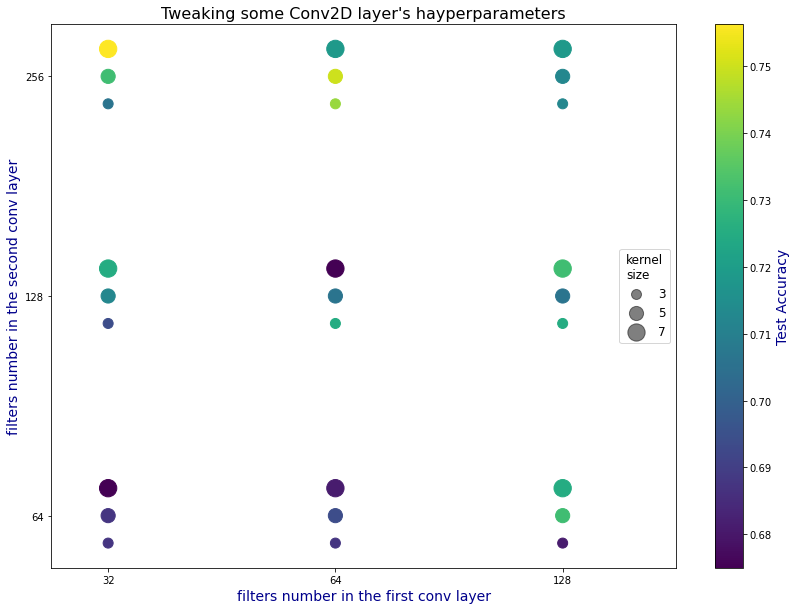

In [ ]:
fig = plt.figure(figsize=(14,10))

plt.scatter(xx,yy,s=ss,c=cc)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Test Accuracy',fontdict={'fontsize':14,'color':'darkblue'})

plt.xlim(1.5,7)
plt.xticks([2,4,6],labels=n_filter1)
plt.yticks([5,13,21],labels=n_filter2)
plt.xlabel('filters number in the first conv layer', fontdict={'fontsize':14,'color':'darkblue'})
plt.ylabel('filters number in the second conv layer', fontdict={'fontsize':14,'color':'darkblue'})
plt.title("Tweaking some Conv2D layer's hayperparameters", fontdict={'fontsize':16})

plt.scatter([],[],s=100,c='k',alpha=0.5,label='3')
plt.scatter([],[],s=200,c='k',alpha=0.5,label='5')
plt.scatter([],[],s=300,c='k',alpha=0.5,label='7')
plt.legend(loc='center right', title='kernel\nsize', fontsize=12, title_fontsize=12)

save_figure('n_filters_and_kernel_sizes__vs__test_accuracy')
plt.show()
del fig



6.   Dense Layers and Units (Search):


it's highly recommended that the Dense layers to be having the same number of units per layer, and the opposite doesn't make a big difference, so I will be adopting this advice in the next piece of code.

In [ ]:
%%time
## Disclamer "running this code will take 18 min (GPU)"

n_layers = [1,2,3]    # number of layers
n_units = [256,512,1024,2048,4096]  # the corresponding units

xxx = []
yyy = []
sss = []
ccc = []

for i in n_layers:
  print('n_layers = {} :: '.format(i), end=' ')
  for j in range(len(n_units)):
    tic = time.time()
    
    tmp = build_model(hidden_layers_units=[n_units[j]]*i, drop_rate=.3,
                      activation='sigmoid', initializer='he_normal',optimizer='adam',learning_rate=10**-4,
                      n_conv_filters=[32,256] , kernels_sizes=[7,3])
    h = tmp.fit(X_train,y_train,validation_data=(X_test,y_test),
                epochs=60,batch_size=16,verbose=0,callbacks=[early_stopping])
    test_score = tmp.evaluate(X_test,y_test,verbose=0)[1]
    
    xxx.append(i)
    yyy.append(1.2**j)
    sss.append(n_units[j]/2)
    ccc.append(np.round(test_score,3))

    toc = int(time.time() - tic)
    toc = str(toc//60) + 'm' + str(toc%60) + 's'
    print("{}/{} DONE in {}! ".format((i-1)*len(n_units)+j+1 ,
                                      len(n_layers)*len(n_units) ,
                                      toc) ,end='   ')
    
    del tmp, h
  print()


n_layers = 1 ::  1/15 DONE in 0m25s!    2/15 DONE in 0m33s!    3/15 DONE in 0m53s!    4/15 DONE in 1m34s!    5/15 DONE in 2m31s!    
n_layers = 2 ::  6/15 DONE in 0m25s!    7/15 DONE in 0m34s!    8/15 DONE in 0m55s!    9/15 DONE in 1m36s!    10/15 DONE in 3m6s!    
n_layers = 3 ::  11/15 DONE in 0m26s!    12/15 DONE in 0m36s!    13/15 DONE in 0m57s!    14/15 DONE in 1m40s!    15/15 DONE in 2m6s!    
CPU times: user 6min 24s, sys: 43.7 s, total: 7min 8s
Wall time: 18min 26s


saving figure:  dense_layers_and_units__vs__test_accuracy


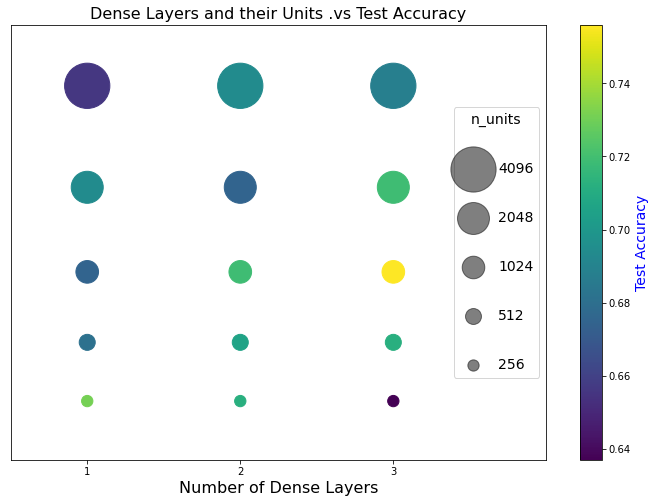

In [ ]:
fig = plt.figure(figsize=(12,8))

plt.scatter(xxx, yyy, s=sss, c=ccc)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Test Accuracy', fontdict={'fontsize':14,'color':'b'})

plt.xticks(n_layers)
plt.xlim(0.5,xxx[-1]+1)
plt.yticks([])
plt.ylim(0.8,1.1*yyy[-1])
plt.xlabel('Number of Dense Layers',fontdict={'fontsize':16})
plt.title('Dense Layers and their Units .vs Test Accuracy',fontdict={'fontsize':16})
for u in n_units[::-1]:
  plt.scatter([],[],s=u/2,c='k',alpha=.5,label=str(u))
plt.legend(loc='center right', prop={'size': 14}, 
           title='n_units', title_fontsize=14, labelspacing=2.5)

save_figure('dense_layers_and_units__vs__test_accuracy')
plt.show()
del fig

# Final Model:





---


*   Final Model


---




In [ ]:
## reshape back the images to their original shape (not vectors anymore)
## we will be working with the RGB images
X = X.reshape([-1]+image_shape)
X_train = X_train.reshape([-1]+image_shape)
X_test = X_test.reshape([-1]+image_shape)

In [ ]:
final_model = build_model(hidden_layers_units=[1024,1024], drop_rate=.3,
                      activation='sigmoid', initializer='he_normal',optimizer='adam',learning_rate=10**-4,
                      n_conv_filters=[32,256] , kernels_sizes=[3,3])

Now let's take a look once again at the settings of the model.

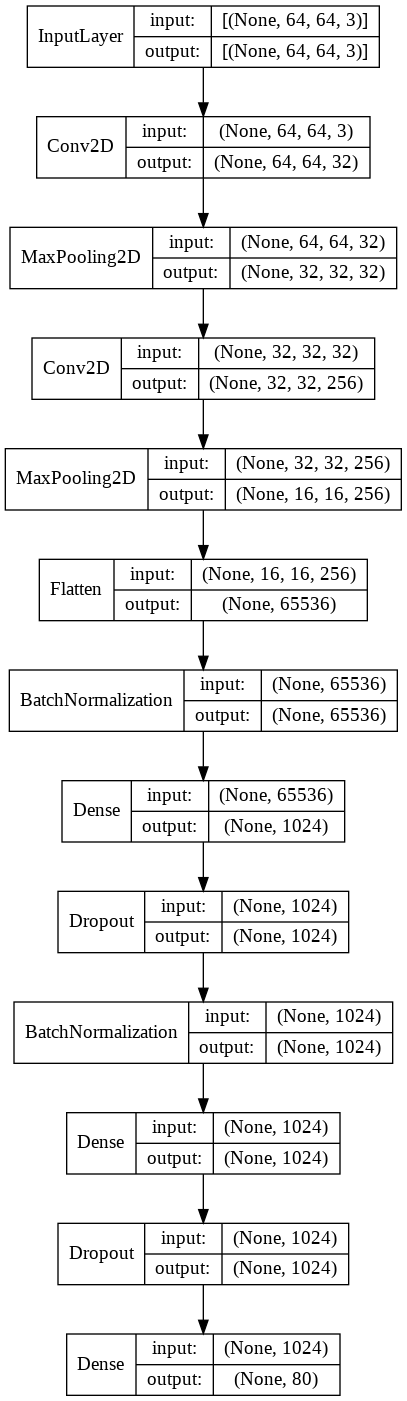

In [ ]:
keras.utils.plot_model(
            final_model, to_file='plots/final_model_plot.png', show_shapes=True, show_layer_names=False)

saving figure:  final_model_hyperparameters


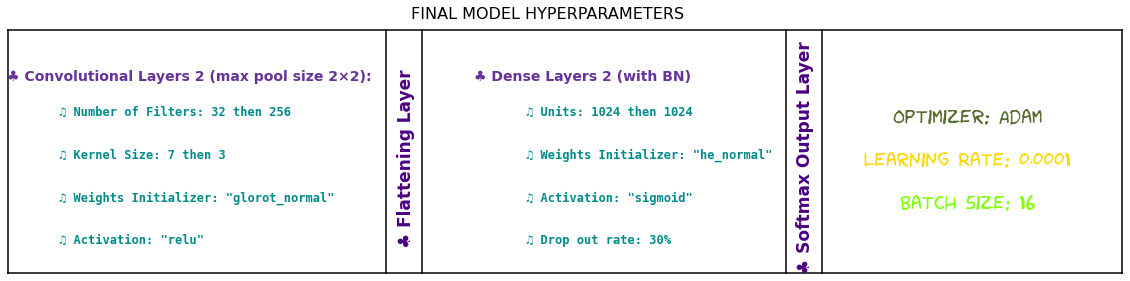

In [ ]:
## Final model's settings
fig = plt.figure(figsize=(20,4.5))

plt.xlim(0,21.5)
plt.ylim(4.3,10)
plt.axis('off')
f1 = {'fontsize':14,'fontweight':'bold','color':'rebeccapurple'}
f11 = {'fontsize':17,'fontweight':'bold','color':'indigo'}
f2 = {'family':'monospace','fontsize':12,'fontweight':'bold','color':'darkcyan'}
f31 = {'family':'fantasy','fontsize':19,'fontweight':'bold','color':'darkolivegreen'}
f32 = {'family':'fantasy','fontsize':19,'fontweight':'bold','color':'gold'}
f33 = {'family':'fantasy','fontsize':19,'fontweight':'bold','color':'chartreuse'}
plt.text(0,8.8,'♣ Convolutional Layers 2 (max pool size 2×2):',fontdict=f1)
plt.text(1,8,'♫ Number of Filters: 32 then 256',fontdict=f2)
plt.text(1,7,'♫ Kernel Size: 7 then 3',fontdict=f2)
plt.text(1,6,'♫ Weights Initializer: "glorot_normal"',fontdict=f2)
plt.text(1,5,'♫ Activation: "relu"',fontdict=f2)
plt.text(7.5,5,'♣ Flattening Layer',rotation=90,fontdict=f11)
plt.text(9,8.8,'♣ Dense Layers 2 (with BN)',fontdict=f1)
plt.text(10,8,'♫ Units: 1024 then 1024',fontdict=f2)
plt.text(10,7,'♫ Weights Initializer: "he_normal"',fontdict=f2)
plt.text(10,6,'♫ Activation: "sigmoid"',fontdict=f2)
plt.text(10,5,'♫ Drop out rate: 30%',fontdict=f2)
plt.text(15.2,4.4,'♣ Softmax Output Layer',rotation=90,fontdict=f11)
plt.text(18.5,7.9,'Optimizer: Adam',ha='center',fontdict=f31)
plt.text(18.5,6.9,'Learning Rate: 0.0001',ha='center',fontdict=f32)
plt.text(18.5,5.9,'Batch Size: 16',ha='center',fontdict=f33)
fig.suptitle(y=0.95,t='FINAL MODEL HYPERPARAMETERS',size=16)
plt.hlines(9.99,0,25)
plt.hlines(4.31,0,25)
plt.vlines(0.01,0,10)
plt.vlines(7.3,0,10)
plt.vlines(8,0,10)
plt.vlines(15,0,10)
plt.vlines(15.7,0,10)
plt.vlines(21.47,0,10)
save_figure('final_model_hyperparameters')
plt.show()

del fig

let's have an idea about how images are transformed and transmitted through the convolutional layers, to do that we will pick a single random photo.

In [ ]:
random_index = np.random.randint(0,N*m)
image, name = X[random_index], names[y[random_index]]

XX = image.reshape([1]+image_shape)  ## Shape = (1,height,width,3)
outputs = []        ## outputs of the conv2d and maxpool2d layers
n = 4 ## n layers
n_show = 16  ## we will pick only first n_show images

for i in range(n):
  tmp = keras.Model(inputs=final_model.inputs, outputs=final_model.layers[i].output)
  out = tmp.predict(XX)[0,:,:,:n_show]      ## we will pick only first n_show images
  
  out = out.T                               ## trying to build a short fat block of these images
  out = out.reshape((-1,out.shape[2]))
  out = out.T
  
  outputs.append(out)           ## len(out) = n , n short fat blocks
  del tmp, out

del XX

saving figure:  filters_and_pooling_vis


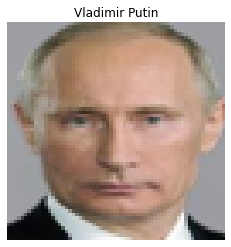

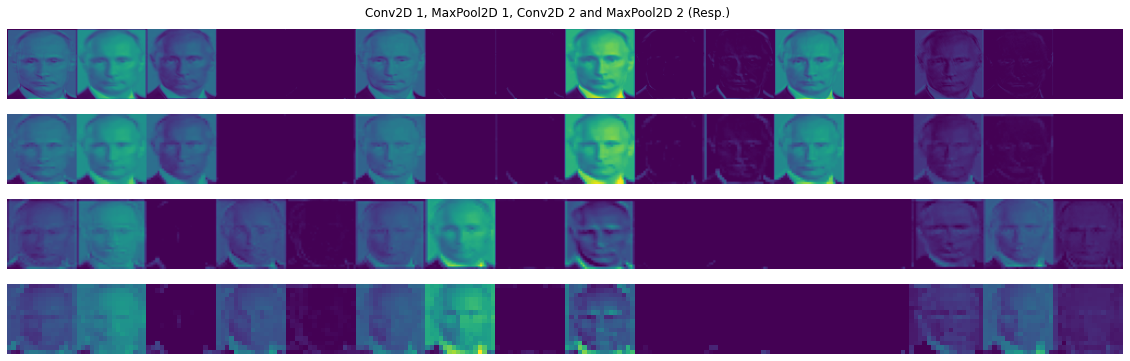

In [ ]:
## plot these blocks
plt.imshow(image)
plt.axis('off')
plt.title(name)

fig = plt.figure(figsize=(20,6))
fig.suptitle(y=0.93,t='Conv2D 1, MaxPool2D 1, Conv2D 2 and MaxPool2D 2 (Resp.)')

for i in range(n):
  ax = plt.subplot(n,1,i+1)
  ax.imshow(outputs[i])
  ax.set_axis_off()

save_figure('filters_and_pooling_vis')
plt.show()
del fig, outputs

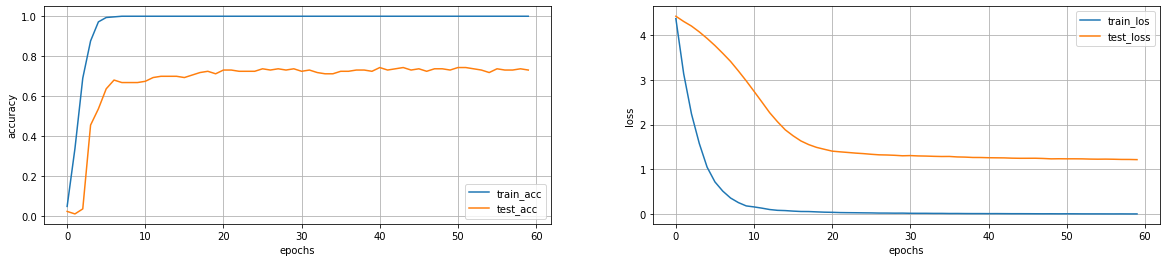

saving figure:  final_model_perform


<Figure size 432x288 with 0 Axes>

In [ ]:
hist = final_model.fit(X_train,y_train,validation_data=(X_test,y_test),
                       epochs=60,batch_size=16,verbose=0)
acc_nd_loss(hist)
save_figure('final_model_perform')
del hist

Now we feed the training data to the model.

saving figure:  final_model_all_wrong_pred


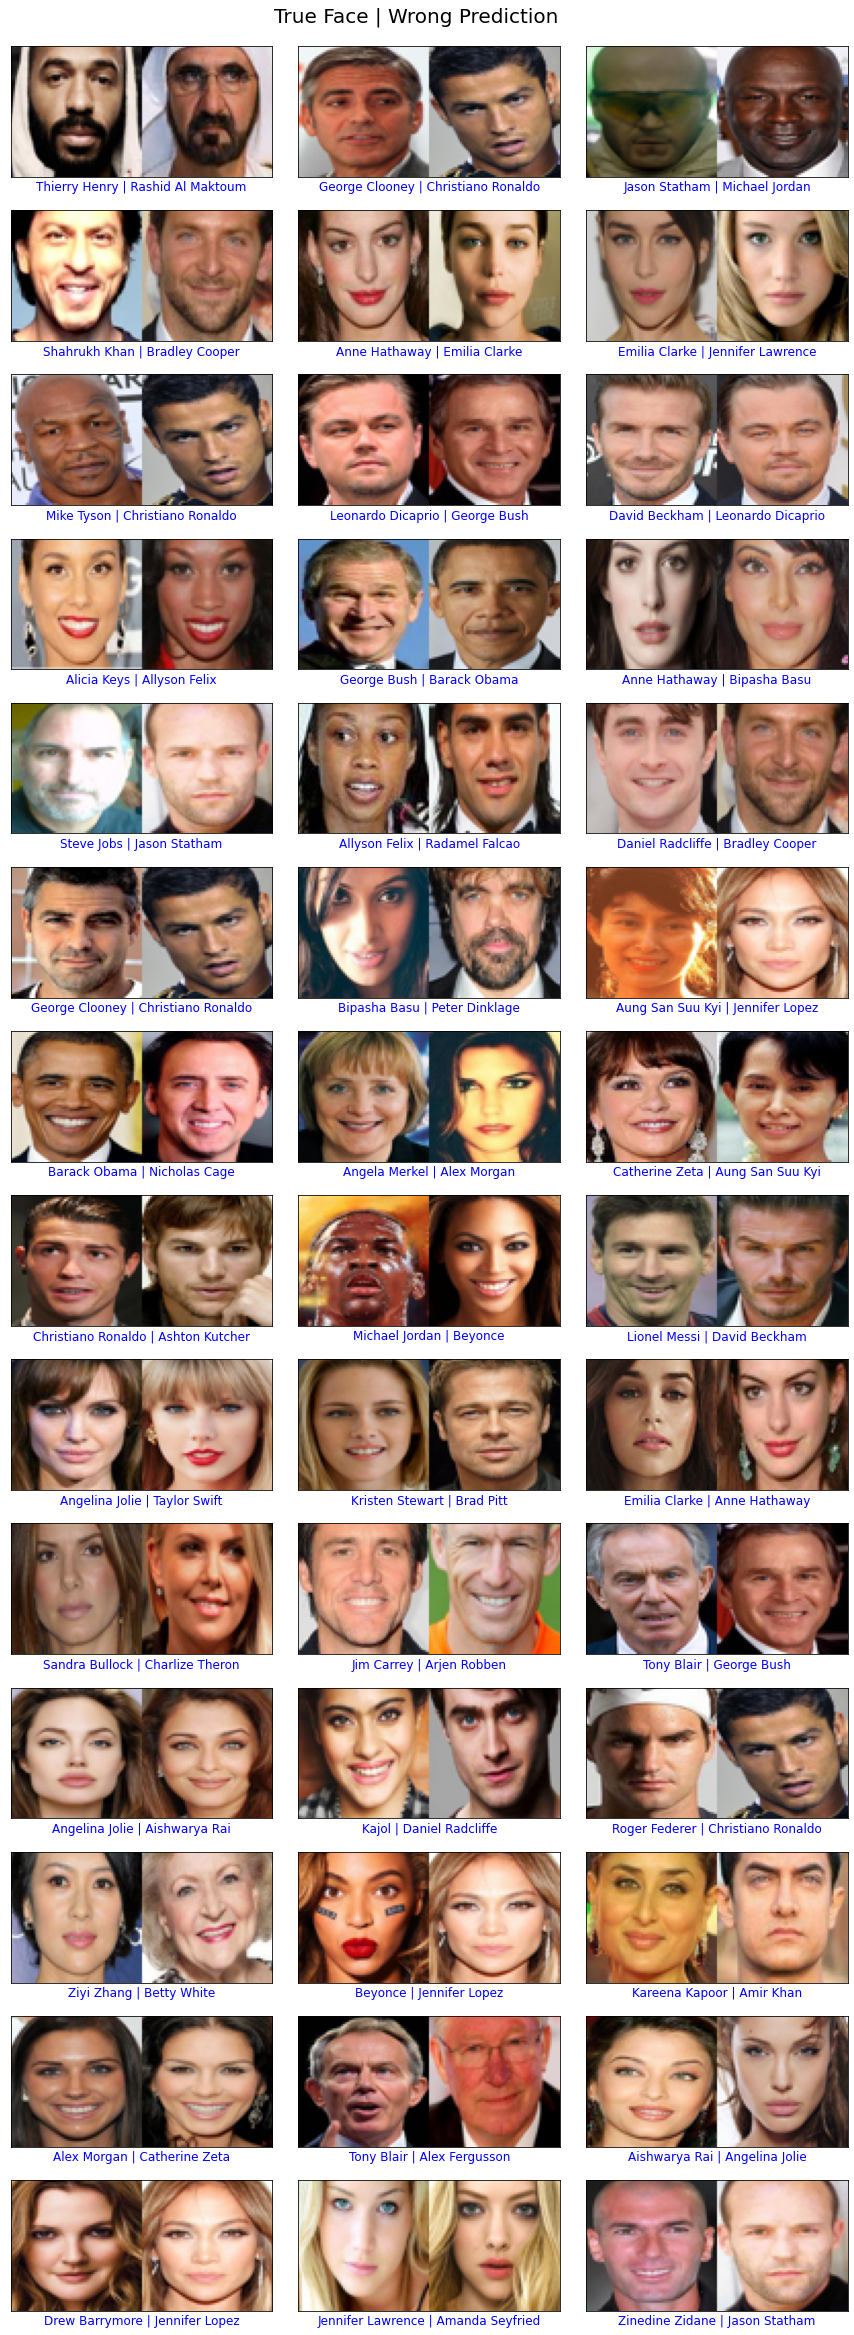

In [ ]:
## all the wrong prediction that the final model made
## predict method gives an array with probabilities
y_test_pred = final_model.predict(X_test).argmax(axis=1)  
n_wrong = sum(y_test != y_test_pred)   # number of wrong prediction in the test set
messy_celeb(y_test,y_test_pred, n_wrong)
save_figure('final_model_all_wrong_pred')

In [ ]:
# save and download the model
final_model.save('final_model.h5')
# 262 Mo !!

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Predictions:

Now we will be using this model to make predictions thanks to the function `predictor_v1` that return the class and the probability of being that class, note that this probability will be significantly low, this is evident since the images that we will be predicting their class do not exist in the dataset, and we want to seek the celebrity the most probable that can be assigned to this extern image, so we can call it likeness, similarity or resemblance.

In [ ]:
def predictor_v1(arr):
  arr = arr.reshape([1]+image_shape)     ## Shape = (1,height,width,3)
  y_pred = final_model.predict(arr)[0]   ## predict
  return y_pred.argmax() , np.round(100*y_pred.max(),2)     ## class, likeness

Yes, the first thing comes in mind is K-Nearest-Neighbors, KNN can yields the class of the closest celebrity in the high-dimensional space of the dataset, so we will define a function `predictor_v2` that provides the probabilty that this model is sure in making the given prediction (this one can be easily 100% if all the neighbors belongs to the same celebrity), that's why we will choose `n_neighbors=8` because the training data contains 8 images for each celebrity, so the possibility that these neighbors belongs to the same class still holds, so we will call this probability 'certainty'.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

## auxilary model gives the output of before last layer
aux_model = keras.Model(inputs=final_model.inputs,outputs=final_model.layers[-2].output)

## training knn using the output of before last layer of final_model
knn_X_train = aux_model.predict(X_train)
print("the shape of knn_X_train:",knn_X_train.shape)
knn = KNeighborsClassifier(n_neighbors=8).fit(knn_X_train,y_train)

## to know the nearest image:
y_all = np.arange(len(X_train))
knn_1_neighbor = KNeighborsClassifier(n_neighbors=1).fit(knn_X_train,y_all)


def predictor_v2(arr):
  arr = arr.reshape([1]+image_shape)              ## Shape = (1,height,width,3)
  out = aux_model.predict(arr)                  ## output of before last layer

  y_pred = knn.predict_proba(out)               ## predict using knn
  cl, cert = y_pred.argmax(), np.round(100*y_pred.max(),2)   ## class and certainty given by knn
  
  y_all_pred = knn_1_neighbor.predict(out)[0]    ## seeking for the nearest image 
  nearest_image, nearest_y = X_train[y_all_pred], y_train[y_all_pred]

  nearest_bool = False         
  if nearest_y == cl:   ## if knn and knn_1_neighbors make equivalent predictions
    nearest_bool = True              ## True most of cases 

  
  return cl, cert, nearest_image, nearest_bool 

the shape of knn_X_train: (640, 1024)




---



Finally we can upload extern images and apply the above functions, to seek so-called likeness.

In [ ]:
def predict_extern():
  
  up = files.upload()   ## upload images on colab only
  n = len(up)           ## number of images

  fig, ax = plt.subplots(n,3, figsize=(14,4.5*n))
  fig.subplots_adjust(hspace=0.1 , wspace=.2)

  ax = ax.reshape(n,3)  ## in case of uploading a single image

  i = 0             ## row i
  for k in up.keys():
    arr = import_image(k).reshape(image_shape)    ## image to numpy array
    
    cl, likeness = predictor_v1(arr)         ## class and likeness
    knn_cl, cert, nearest_image, nearest_bool = predictor_v2(arr)       ## class, certainty, nearest, bool (knn_1_neighbor)
    
    cert = str(cert)+'%'
    if knn_cl != cl:                      ## in case predictor_v1 and predictore_v2
      cert = 'NaN'                         ## did not make predict the same prediction
    
    celeb = X[10*cl]                         ## Celebrity image
    if knn_cl == cl and nearest_bool :
      celeb = nearest_image                   


    string = 'nearest: '+str(nearest_bool)

    ax[i,0].imshow(arr)                      ## True image
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])

    ax[i,1].text(.5,.7,'Likeness\n'+str(likeness)+"%",
                ha='center',va='center', fontdict={'fontsize':26,'color':'b'})
    ax[i,1].text(.5,.3,'Certainty\n'+cert,
                ha='center',va='center', fontdict={'fontsize':26,'color':'b'})
    ax[i,1].annotate('', xy=(1, 0.5), xytext=(0, 0.5),
                arrowprops=dict(facecolor='black', shrink=0.05))  
    ax[i,1].set_axis_off()
    
    ax[i,2].imshow(celeb)              ## corresponding celebrity
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])
    ax[i,2].set_ylabel(names[cl],
                      fontdict={'fontsize':20,'fontweight':'bold','family':'fantasy'})
    ax[i,2].set_title(string,loc='left',
                      fontdict={'fontsize':10,'fontweight':'light','family':'monospace',
                                'color':'navy','alpha':0.8})
    i+=1

Saving face_199.jpg to face_199.jpg
Saving face-of-peter-1433842.jpg to face-of-peter-1433842 (3).jpg


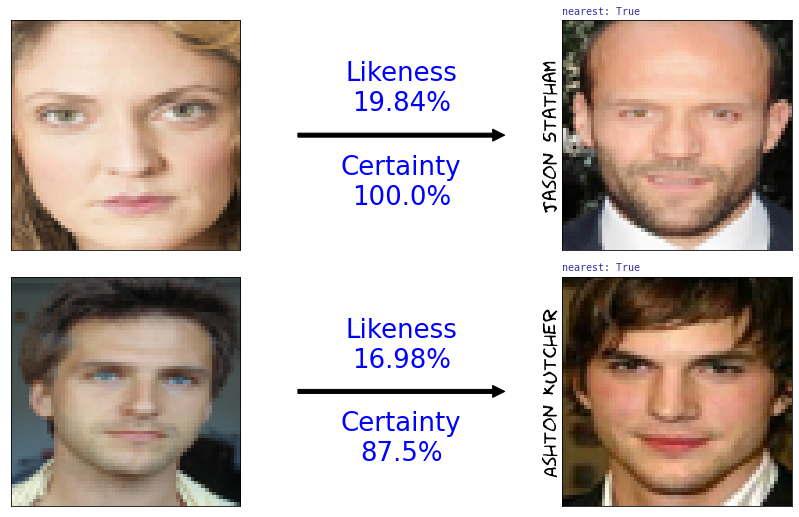

In [ ]:
## TRY
predict_extern()